In [1]:
import netCDF4 as nc
from netCDF4 import Dataset
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# gsw oceanic toolbox: http://www.teos-10.org/pubs/Getting_Started.pdf
import gsw
from scipy.io import loadmat
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

import sys
import os
sys.path.append('../..')
from src.features.processing_func import check_coords, calc_N2_kappa, calc_hab, arctic_calchab
from src.utils.directories import get_parent_directory
from src.features.calc_seaice import calc_SIC

import warnings
import datetime as datetime
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [3]:
SI_HadISST = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/SI-area/HadISST_ice.nc"
Hadi_SI = xr.open_dataset(SI_HadISST)

In [3]:
# the Arctic pickle file loaded after load_ds
arctic_all = pd.read_pickle('/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/processed_data/ml_ready/0106all.pkl')

## Time coverage

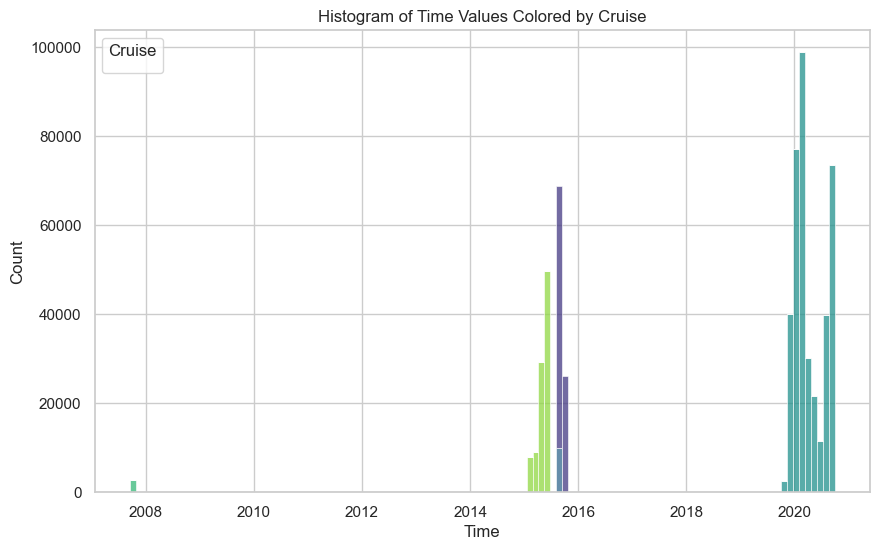

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Assuming you have the array 'arctic_all.time.values' and the corresponding 'arctic_all["cruise"]' strings

# Convert the time values to pandas datetime
time_values = pd.to_datetime(arctic_all.time.values)

# Create a DataFrame with the time values and cruise strings
data = pd.DataFrame({'Time': time_values, 'Cruise': arctic_all["cruise"]})

# Set up Seaborn style
sns.set(style='whitegrid')

# Plot histogram with colored bars
plt.figure(figsize=(10, 6))
ax = sns.histplot(data=data, x='Time', hue='Cruise', multiple='stack', palette='viridis')

plt.xlabel('Time')
plt.ylabel('Count')
plt.title('Histogram of Time Values Colored by Cruise')

# Get unique cruise categories
cruise_categories = data['Cruise'].unique()

# Get histogram handles and labels
handles, labels = ax.get_legend_handles_labels()

# Create legend patches for each cruise category
legend_patches = [mpatches.Patch(color=handles[i].get_facecolor(), label=label) for i, label in enumerate(labels) if label in cruise_categories]

# Manually create legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title='Cruise')

# Add custom legend
plt.legend(handles=legend_patches, title='Cruise')

# Display the plot
plt.show()

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have the array 'arctic_all.time.values' and the corresponding 'arctic_all["cruise"]' strings

# Convert the time values to pandas datetime
time_values = pd.to_datetime(arctic_all.time.values)

# Define the seasons and their corresponding indices
seasons = ['Winter', 'Spring', 'Summer', 'Autumn']
season_indices = [1, 4, 7, 10]

# Create a DataFrame with the season labels and cruise strings
data = pd.DataFrame({'Time': time_values, 'Cruise': arctic_all["cruise"]})

# Extract the season information
season_labels = []
for month in data['Time'].dt.month:
    for i, index in enumerate(season_indices):
        if month <= index:
            season_labels.append(seasons[i])
            break
    else:
        season_labels.append(seasons[0])  # Default to the first season if month is greater than the last index

data['Season'] = season_labels

# Set up Seaborn style
sns.set(style='whitegrid')

# Plot histogram of cruise per season
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=data, x='Season', hue='Cruise', palette='viridis')

plt.xlabel('Season')
plt.ylabel('Count')
plt.title('Histogram of Cruise per Season')

# Manually create legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title='Cruise')

# Display the plot
plt.show()


KeyboardInterrupt: 

## Hadi dataset

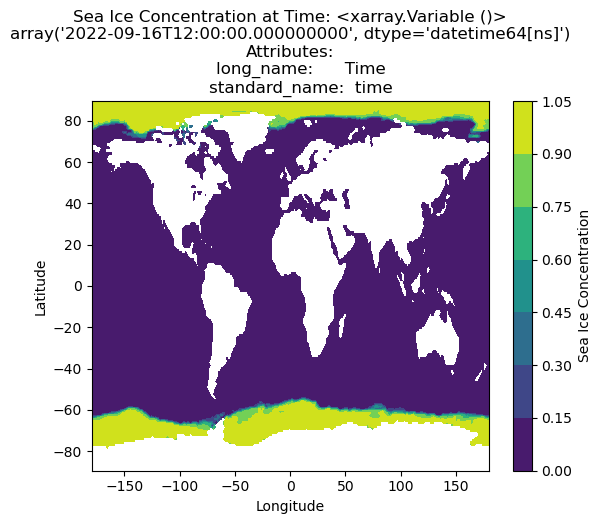

In [9]:
# Select a specific time index or value
time_index = 1832  # Replace with the desired time index
selected_time = Hadi_SI.variables['time'][time_index]
sea_ice_concentration_data = Hadi_SI.variables['sic'][time_index]

latitude = Hadi_SI.variables['latitude']  
longitude = Hadi_SI.variables['longitude']
# Create a meshgrid for the latitude and longitude values
lon, lat = np.meshgrid(longitude[:], latitude[:])

# Plot the sea ice concentration
plt.contourf(lon, lat, sea_ice_concentration_data, cmap='viridis')
plt.colorbar(label='Sea Ice Concentration')
plt.title(f'Sea Ice Concentration at Time: {selected_time}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Close the NetCDF file
Hadi_SI.close()

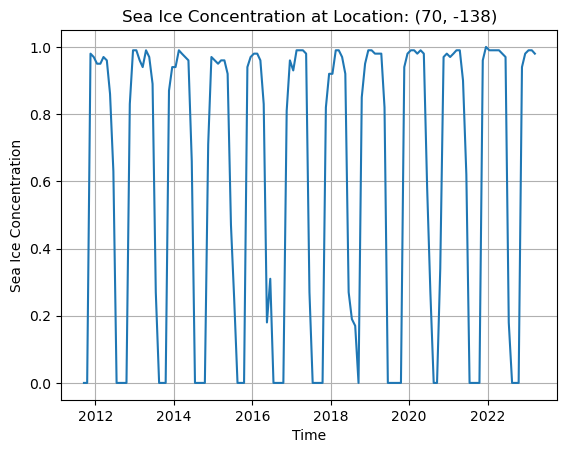

In [10]:
# Read the sea ice concentration variable
sea_ice_concentration = Hadi_SI.variables['sic']  # Replace with the actual variable name

# Specify the location coordinates (replace with desired values)
target_lat = 70
target_lon = -138

# Find the nearest latitude and longitude indices for the target location
lat_index = np.nanargmin(np.abs(latitude[:] - target_lat))
lon_index = np.nanargmin(np.abs(longitude[:] - target_lon))

# Extract the sea ice concentration data for the target location
sea_ice_concentration_location = sea_ice_concentration[:, lat_index, lon_index]

# Read the time variable
time = Hadi_SI.variables['time'] # Replace with the actual time variable name

# Convert time values to datetime objects
#time_values = nc.num2date(time[:], time.units)

# Plot sea ice concentration over time
plt.plot(time[1700:], sea_ice_concentration_location[1700:])
plt.xlabel('Time')
plt.ylabel('Sea Ice Concentration')
plt.title(f'Sea Ice Concentration at Location: ({target_lat}, {target_lon})')
plt.grid(True)
plt.show()

# Close the NetCDF file
Hadi_SI.close()

# Calculate sea ice cover

In [4]:
arctic_mix = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/processed_data/arctic_mix.nc"
alberto_nc = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/processed_data/alberto_ds.nc"
global_pkl = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/input_microstructure.pkl"
global_nc = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/L2_2D_snapshot_iy150_model_input.nc"
mosaic_nc = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/processed_data/mosaic_ds.nc"
nice_nc = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/processed_data/nice_ds.nc"
HM_nc = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/processed_data/HM_ds.nc"
NN_nc = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/L2_2D_snapshot_iy150_model_input.nc"

arctic_ds = xr.open_dataset(arctic_mix)
alberto_ds = xr.open_dataset(alberto_nc)
global_ds = pd.read_pickle(global_pkl)
global_nn = xr.open_dataset(global_nc)
mosaic_ds = xr.open_dataset(mosaic_nc)
nice_ds = xr.open_dataset(nice_nc)
HM_ds = xr.open_dataset(HM_nc)
NN_ds = xr.open_dataset(NN_nc)

In [5]:
HM_ds = calc_SIC(HM_ds, Hadi_SI)

In [28]:
alberto_ds = calc_SIC(alberto_ds, Hadi_SI)

In [30]:
mosaic_ds = calc_SIC(mosaic_ds, Hadi_SI)

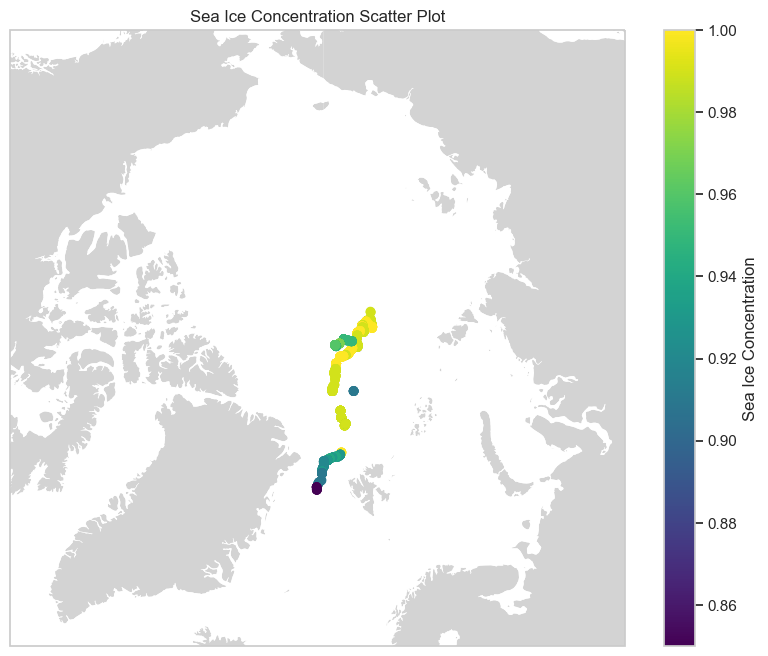

In [17]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Define the desired extent for the plot
extent = [-180, 180, 65, 90]  # [lon_min, lon_max, lat_min, lat_max]

# Create a figure and axis with an orthographic projection centered on the Arctic and the defined extent
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": ccrs.Orthographic(central_longitude=0, central_latitude=90)})
ax.set_extent(extent, crs=ccrs.PlateCarree())

# Plot land and ocean features
ax.add_feature(cfeature.LAND, facecolor="lightgray")
ax.add_feature(cfeature.OCEAN, facecolor="white")

# Extract the variables from mosaic_ds
lon = mosaic_ds["longitude"].values
lat = mosaic_ds["latitude"].values
sic = mosaic_ds["sea_ice_concentration"].values

# Create a scatter plot
sc = ax.scatter(lon, lat, c=sic, cmap="viridis", transform=ccrs.PlateCarree())
plt.colorbar(sc, label="Sea Ice Concentration")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Sea Ice Concentration Scatter Plot")

# Show the plot
plt.show()

In [18]:
# Define the seasons and their corresponding indices
seasons = ['Winter', 'Spring', 'Summer', 'Autumn']
season_indices = [1, 4, 7, 10]

data = mosaic_ds
# Extract the season information
season_labels = []
for month in data['time'].dt.month:
    for i, index in enumerate(season_indices):
        if month <= index:
            season_labels.append(seasons[i])
            break
    else:
        season_labels.append(seasons[0])  # Default to the first season if month is greater than the last index

data['Season'] = season_labels

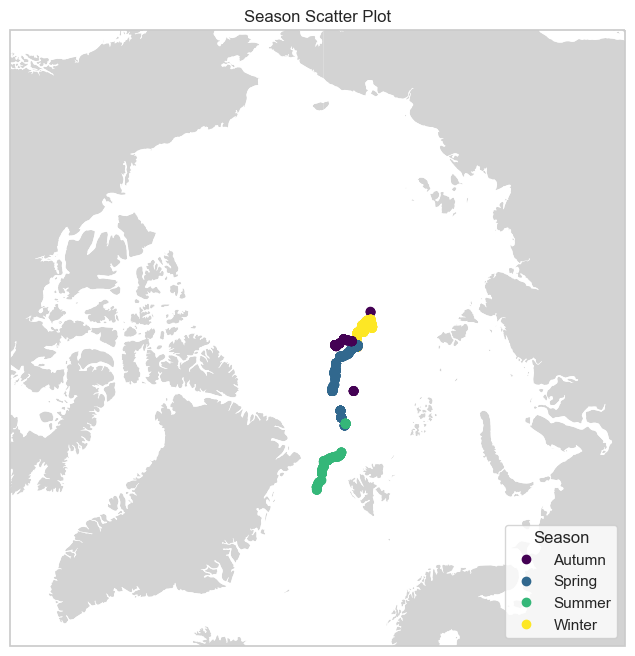

In [20]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

# Define the desired extent for the plot
extent = [-180, 180, 65, 90]  # [lon_min, lon_max, lat_min, lat_max]

# Create a figure and axis with an orthographic projection centered on the Arctic and the defined extent
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": ccrs.Orthographic(central_longitude=0, central_latitude=90)})
ax.set_extent(extent, crs=ccrs.PlateCarree())

# Plot land and ocean features
ax.add_feature(cfeature.LAND, facecolor="lightgray")
ax.add_feature(cfeature.OCEAN, facecolor="white")

# Extract the variables from mosaic_ds
lon = mosaic_ds["longitude"].values
lat = mosaic_ds["latitude"].values
season = data["Season"].values

# Convert categorical values to numeric codes
season_codes = pd.Categorical(season).codes

# Create a scatter plot with numeric codes as color values
sc = ax.scatter(lon, lat, c=season_codes, cmap="viridis", transform=ccrs.PlateCarree())

# Create a legend for the seasons
season_labels = pd.Categorical(season).categories
legend = ax.legend(*sc.legend_elements(), title="Season", loc="lower right")
legend.set_title("Season")
for text, label in zip(legend.get_texts(), season_labels):
    text.set_text(label)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Season Scatter Plot")

# Show the plot
plt.show()


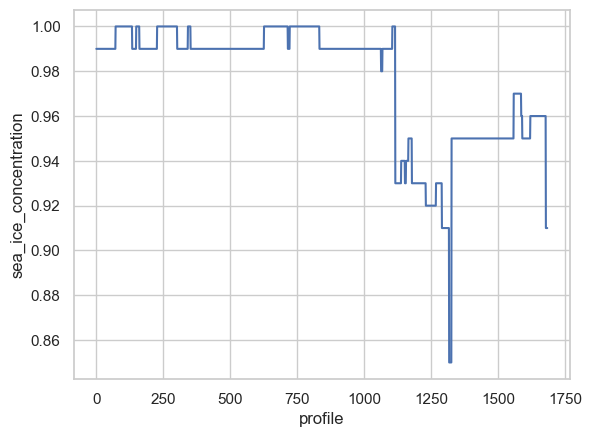

In [31]:
mosaic_ds.sea_ice_concentration.plot()

## Investigate epsilon plots

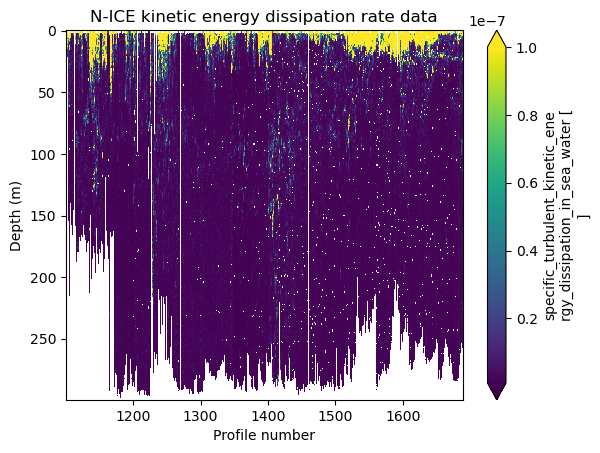

In [77]:
nice_ds.eps.plot(vmin= 1e-9, vmax=1e-7)
plt.gca().invert_yaxis() 
plt.title("N-ICE kinetic energy dissipation rate data")
plt.xlabel("Profile number")
plt.ylabel("Depth (m)")
plt.show()

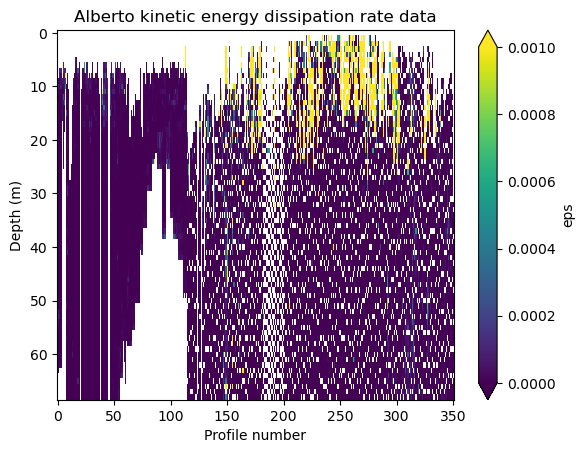

In [34]:
alberto_ds.eps.plot(vmin = 1e-15, vmax=1e-3, cmap = 'viridis')
plt.gca().invert_yaxis() 
plt.title("Alberto kinetic energy dissipation rate data")
plt.xlabel("Profile number")
plt.ylabel("Depth (m)")
plt.show()

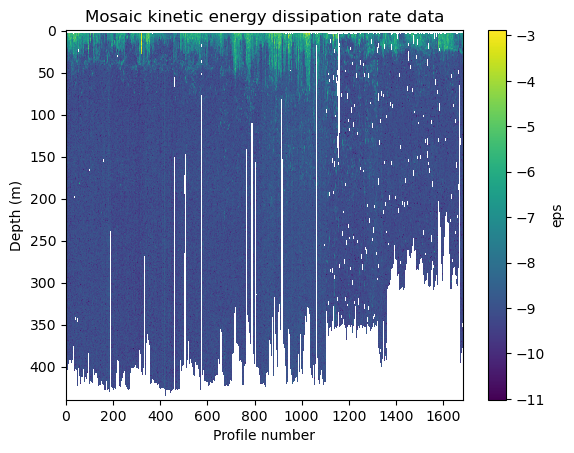

In [16]:
mosaic_ds.eps.plot()
plt.gca().invert_yaxis() 
plt.title("Mosaic kinetic energy dissipation rate data")
plt.xlabel("Profile number")
plt.ylabel("Depth (m)")
plt.show()

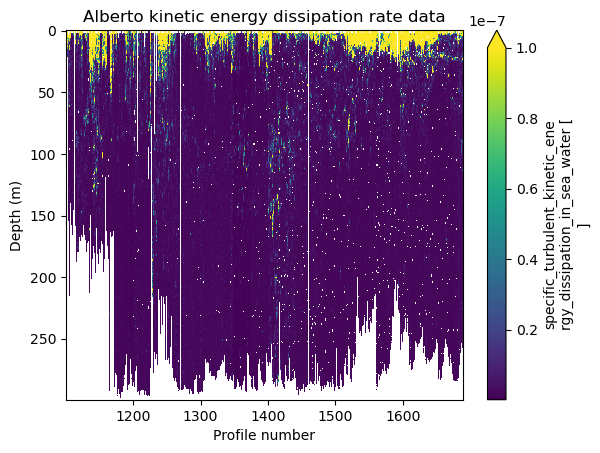

In [51]:
nice_ds.eps.plot(vmin = 1e-10, vmax=1e-7, cmap = 'viridis')
plt.gca().invert_yaxis() 
plt.title("Alberto kinetic energy dissipation rate data")
plt.xlabel("Profile number")
plt.ylabel("Depth (m)")
plt.show()

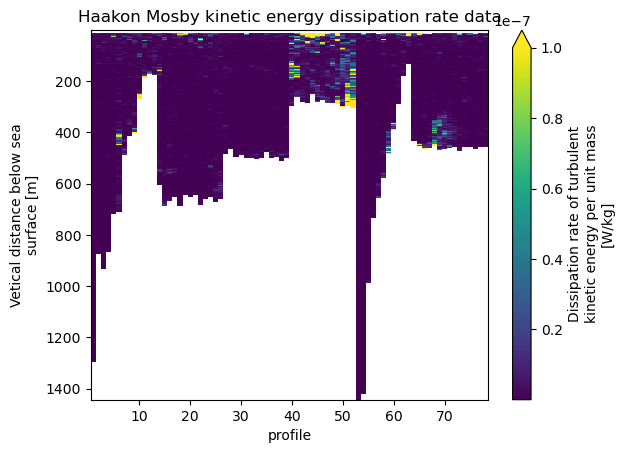

In [68]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a variable called 'HM_ds' containing your dataset

# Transpose the dataset
transposed_data = HM_ds.transpose()

# Plotting with specified vmin, vmax, and cmap
transposed_data.eps.plot(vmin=1e-12, vmax=1e-7, cmap='viridis')

# Invert the y-axis
plt.gca().invert_yaxis()

# Add title
plt.title("Haakon Mosby kinetic energy dissipation rate data")

# Display the plot
plt.show()
